In [1]:
import numpy as np
# import sympy as symb
# from sympy import sin,cos
# from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
import copy

In [2]:
dt = 0.05
nx = 21
ny = 21
tstep = 100
D = 1.
dx = 2./(nx-1)
dy = 2./(ny-1)
phi = np.zeros([tstep,nx+2,ny+2]) # 1~21 for domain 0,22 for ghost point
# f_interm = np.empty[nx+2,ny+2]
# init condition
phi[0,:,:] = 0.
zeta = np.zeros([tstep,nx+2,ny+2])
f    = np.zeros([tstep,nx+2,ny+2])
# set q value
# set domain location
x_real = np.linspace(-1,1,nx)
y_real = np.linspace(-1,1,ny)
q    = np.zeros([nx+2,ny+2])
for i in range(1,nx+1):
    # print(-1+dx*(i-1))
    for j in range(1,ny+1):
        q[i,j] = 2*(2 - x_real[i-1]**2 - y_real[j-1]**2)        

In [3]:
# Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
                
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [4]:
for it in range(0,20):
    # count f
    f_interm = np.zeros([nx+2,ny+2])
    f_interm[:,:] = 0.
    for i in range(2, nx):
        for j in range(2, ny):
            # f_interm[:,:] = 0.
            f_interm[i,j] = phi[it,i,j] + (dt/2/dx**2) * (phi[it,i+1,j]    +  phi[it,i-1,j]   - 2*phi[it,i,j])

    for i in range(2, nx):
        for j in range(2, ny):
            f[it,i,j] = f_interm[i,j]   + (dt/2/dx**2) * (f_interm[i,j+1]  +  f_interm[i,j-1] - 2*f_interm[i,j])
    # count zeta
    # 对x方向进行扩散，对y方向 j = 1,21 都进行一次三对角的扩散的计算
    rowa = np.zeros(20)
    rowb = np.zeros(21)
    rowc = np.zeros(20)
    rowd = np.zeros(21)
    # res  = np.zeros(21)
    b    = 1 + dt/dx**2
    a    = -1/2*dt/dx**2
    c    = a
    rowb[:] = b
    rowa[:] = a
    rowc[:] = c
    # add B.C.
    rowa[19] = 0
    rowc[0]  = 0
    rowb[0]  = 1
    rowb[20] = 1  
    # y diffusion -> done for each x
    for i in range(1,nx+1):
        rowd[0:21] = f[it, i, 1:22] + q[i, 1:22]
        rowd[0]  = 0
        rowd[20] = 0
        zeta[it, i, 1:22] = TDMAsolver(rowa,rowb,rowc,rowd)
    # x diffusion -> done for each y
    rowd = np.zeros(21)
    for j in range(1,ny+1):
        rowd[0:21] = zeta[it, 1:22, j]
        rowd[0]    = 0
        rowd[20]   = 0
        phi[it+1, 1:22, j]  = TDMAsolver(rowa,rowb,rowc,rowd)



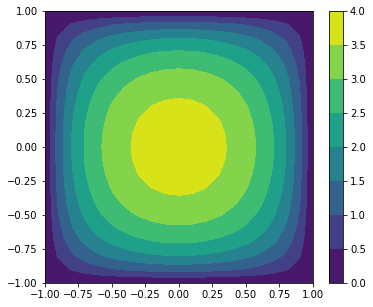

In [11]:

import matplotlib as mpl
fig,ax = plt.subplots(1,1,figsize=(6,5))
# custom_zlim = (0, 2.0)
# plt.setp(ax, zlim=custom_zlim, ylim=custom_ylim)
# norm = mpl.colors.Normalize(vmin=0, vmax=70.)
# levels_bnd = [0,0.1,1,2,3,4,5,10,60]
# levels_bnd = [0,0.1,0.5,1,2,3,4]
# cnrt = ax.contourf(np.linspace(-1,1,21),np.linspace(-1,1,21),zeta[5,1:22,1:22]-zeta[1,1:22,1:22],cmap="RdBu_r")
cnrt = ax.contourf(np.linspace(-1,1,21),np.linspace(-1,1,21),phi[1,1:22,1:22])
# cnrt = ax.contourf(np.linspace(-1,1,21),np.linspace(-1,1,21),phi[25,1:22,1:22]-phi[1,1:22,1:22],cmap="RdBu_r")
# cnrt = ax.contourf(np.linspace(-1,1,21),np.linspace(-1,1,21),f[5,1:22,1:22],cmap="RdBu_r")
# cnrt = ax.contourf(np.linspace(-1,1,21),np.linspace(-1,1,21),f[2,1:22,1:22],cmap="RdBu_r")
# ax.clabel(cnrt,fontsize=10,fmt='%4.1f')
# ax1 = ax[1].contourf(np.linspace(0,domainlx,gridnx),np.linspace(0,domainly,gridny),c[:,:,int(1./deltat)],levels = 10,cmap="RdBu_r",norm = norm,vmin=0,vmax=0.8,level=6)
# im = ax.imshow(data, cmap='bone')
# im.clim(vmin=0,vmax=70)
plt.colorbar(cnrt,ax=ax)
# plt.clim(0,70)
# bound = [0, 10, 20, 40 ,50 ,70]
# plt.xlabel('x distance(m)')
# plt.ylabel('concentrations (mg/L^3)')
# plt.title('BOD')